In [39]:
import numpy as np
with open("/Users/gcgibson/Stein-Variational-Gradient-Descent/python/dat.json") as f:
    dat = f.read()
    
    
    dat = dat.split(",")
    time = []
    cases = []
    count = 0
    for elm in dat:
        if count % 2 ==0:
            time.append(elm.split(":")[1])
        else:
            cases.append(int(elm.split(":")[1].replace("}","").replace(']"]\n',"")))
        count +=1


cases = np.array(cases)
cases = cases/(1.0*np.max(cases))
beta0 = .1
mu = 1/(200.0*110)

"""
Y[0] = mu - beta*V[0]*V[1] - mu*V[0]
	Y[1] = beta*V[0]*V[1] - mu*V[1] - gamma*V[1]
	Y[2] = gamma * V[1] - mu * V[2]
"""

def fa(a,b,c,alpha,beta):
    return mu -beta*a*b - mu*a

def fb(a,b,c,alpha,beta):
    return beta*a*b - alpha*b - mu*b
def fc(a,b,c,alpha,beta):
    return alpha*b - mu*c

def rK3(a, b, c, fa, fb, fc, hs,alpha,beta,t):
    beta=beta*(1+ np.sin(2*np.pi*t/110))
    
    a1 = fa(a, b, c, alpha, beta)*hs
    b1 = fb(a, b, c, alpha, beta)*hs
    c1 = fc(a, b, c, alpha, beta)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(ak, bk, ck, alpha, beta)*hs
    b2 = fb(ak, bk, ck, alpha, beta)*hs
    c2 = fc(ak, bk, ck, alpha, beta)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(ak, bk, ck, alpha, beta)*hs
    b3 = fb(ak, bk, ck, alpha, beta)*hs
    c3 = fc(ak, bk, ck, alpha, beta)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(ak, bk, ck, alpha, beta)*hs
    b4 = fb(ak, bk, ck, alpha, beta)*hs
    c4 = fc(ak, bk, ck, alpha, beta)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

def forward_sample(theta):
    alpha = theta[0]
    beta = theta[1]
    a, b, c, hs = .9, .001, 0, 0.05
    a_arr = []
    b_arr = []
    c_arr = []
    #t_range = 
    for i in range(len(cases)):
        a, b, c = rK3(a, b, c, fa, fb, fc, hs, alpha, beta,i)
        a_arr.append(a)
        b_arr.append(b)
        c_arr.append(c)
    return b_arr

import emcee
from scipy.stats import norm
d2 = np.array(forward_sample([.2,1.9]))

def distance_abc(theta):
   # print (np.mean(np.power((np.array(b_arr)-np.array(cases[:200])),2)))
    tmp = -np.sum(np.power(np.array(forward_sample(np.exp(theta)))-cases,2))
    #print (tmp + norm.logpdf(theta,0,1) )
    ret_val = tmp + norm.logpdf(theta,0,10)
    if np.isnan(ret_val).any():
        ret_val = -10000000*np.ones(2)
    #print (ret_val.shape)
    return ret_val.sum()

ndim, nwalkers = 2, 10
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, distance_abc)
sampler.run_mcmc(p0, 1000)


/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in power


(array([[-0.69375166,  0.75820916],
        [-1.34599392, -0.53025452],
        [-1.15489056, -0.1696147 ],
        [-1.07976536, -0.34290822],
        [-1.3491498 , -0.38482699],
        [-1.53357531, -0.38704829],
        [-1.25467919, -0.3780346 ],
        [-0.40229475,  0.7426802 ],
        [-0.5635759 ,  0.67855292],
        [-0.72527238,  0.71677491]]),
 array([-59.12376088, -58.77351633, -58.41609276, -59.08112389,
        -57.88915388, -59.75870553, -57.90886025, -58.8272537 ,
        -58.21557317, -58.69684645]),
 ('MT19937', array([2018476531, 2931342584, 2052255306,  536810047, 3009045161,
         2670222944,  642549853, 2197467716, 1060005970, 3701453110,
         4109120634, 1434765959,  719072481,  912550750,   71396552,
         2563984188, 2580409064, 1588380076, 1031746024, 3763941332,
         4131738600, 2524287913,  748921405, 2201579651, 1502212645,
          142923574, 3432710457, 3865027336, 4090838480, 2111894967,
          172628405,  711418704, 3591105019,   

1.0934081496627583


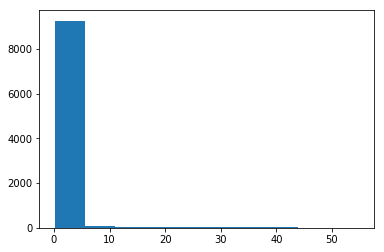

1.5145047271248413


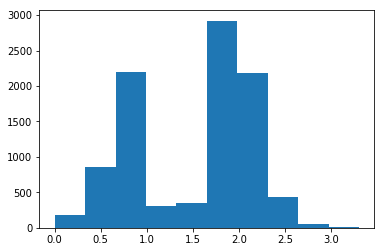

In [40]:
import matplotlib.pyplot as plt

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
print (np.mean(np.exp(samples[:,0])))
plt.hist(np.exp(samples[:,0]))
plt.show()
print (np.mean(np.exp(samples[:,1])))
plt.hist(np.exp(samples[:,1]))
plt.show()

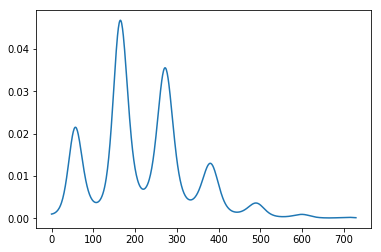

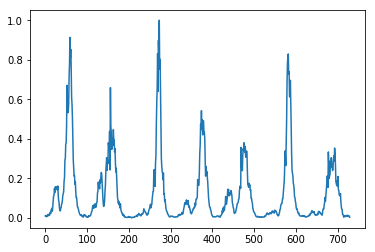

In [41]:
alpha =  np.mean(np.exp(samples[:,0]))
beta = np.mean(np.exp(samples[:,1]))
plt.plot(forward_sample([alpha,beta]))
plt.show()
plt.plot(cases)
plt.show()